This notebook is made to create and test the models we used for our application and to report the final results.

We use 3 seconds long audio files and previously created training datasets, which are made using the notebook *Create_training_dataset.ipynb*.

We will use spectrogram images with the parameters *hop_length = 1024* and *n_coef = 20*, which will result in images having 128x130 resolution.

In [45]:
%matplotlib inline

from IPython.display import Audio
from IPython.display import Image


import sklearn.preprocessing
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np 
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt
import wave
import soundfile as sf
import math

#from specAugment import spec_augment

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In the cell below, you should enter the username which leads the wanted directory.\
\
If you are not using the same setup as advised in *Create_training_dataset.ipynb* notebook and the *Technical_documentation.pdf*, you should enter your paths manually.\
\
You should also enter the instrument which you want to create your model as the *instrument_of_interest* variable, in this notebook it is "gac"

In [46]:
hop_length = 1024
n_coef = 128

username = "user"
directory = "C:/Users/" + username + "/Downloads/IRMAS_Training_Data/IRMAS_Training_Data"
directory_names = os.listdir(directory)
instrument_of_interest = "gac"
redni_broj = directory_names.index(instrument_of_interest)

In [47]:
directory_names = np.array(directory_names)
n=0
m = directory_names.size
br_fileova = np.zeros(m)
i=0
for instrument in directory_names:
    directory_path = os.path.join("C:/Users/" + username + "/Downloads/IRMAS_Training_Data/IRMAS_Training_Data", instrument)
    file_list = os.listdir(directory_path)
    br_fileova[i] = np.size(file_list)
    i = i + 1
    n = n + np.size(file_list) 
    
br_fileova = br_fileova.astype(int) 
print(br_fileova)
print(n)

[388 505 451 637 760 682 721 626 577 580 778]
6705


In [48]:
directory_path = os.path.join(directory, instrument_of_interest)
file_list = os.listdir(directory_path)

mel_sgram_tensor1=np.zeros((br_fileova[redni_broj],n_coef,130))
iter = 0

for file in file_list:
        
    file_path = os.path.join(directory_path, file)
    y, sr = librosa.load(file_path, sr=None)
    
    mel_scale_sgram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = hop_length)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)       
    mel_sgram_tensor1[iter,:,:]=mel_sgram
    
    iter=iter+1


In [49]:
mel_sgram_tensor2=np.zeros((6705-br_fileova[redni_broj],n_coef,130))
iter = 0

for instrument in [x for x in directory_names if x != instrument_of_interest]:
    directory_path = os.path.join(directory, instrument)
    file_list = os.listdir(directory_path)
    
    for file in file_list:
                    
        file_path = os.path.join(directory_path, file)
        y, sr = librosa.load(file_path, sr=None)
        
        mel_scale_sgram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        mel_sgram_tensor2[iter,:,:]=mel_sgram
        
        iter=iter+1

In [50]:
print(mel_sgram_tensor1.shape)
print(mel_sgram_tensor2.shape)

(637, 128, 130)
(6068, 128, 130)


We will take 3000 samples that don't contain our instrument of interest. So let's create labels for the instruments we have right now in the cell below, and then choose those 3000 samples randomly, from the ones that don't contain our instrument of interest.\
\
After we do so, we are left with ~3500 samples where the last 3000 have label 0 and the rest of them label 1. The labels are saved in array *Y* and spectrograms in tensors *mel_sgram_tensor1* and *mel_sgram_tensor2_temp*, which are then concatenated in tensor *mel_sgram_Prvi_dio*.

In [51]:
no_random_examples = 3000 

Y1 = np.ones((br_fileova[redni_broj]))
Y2 = np.zeros(no_random_examples)
Y = np.append(Y1, Y2)

print(Y1.shape)
print(Y2.shape)

(637,)
(3000,)
(3637,)
[1. 1. 1. ... 0. 0. 0.]


(3000, 128, 130)


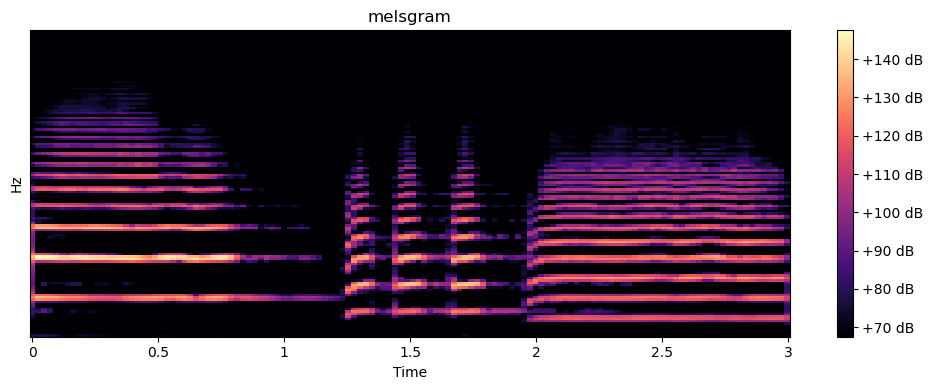

In [52]:
random_indices = np.random.choice(6705-br_fileova[redni_broj], size=no_random_examples, replace=False)

mel_sgram_tensor2_temp = mel_sgram_tensor2[random_indices,:,:]
print(mel_sgram_tensor2_temp.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_sgram_tensor2_temp[222,:,:], x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('melsgram')
plt.xlabel('Time')
plt.ylabel('Hz')
plt.tight_layout()
plt.show()

In [53]:
mel_sgram_Prvi_dio = np.append(mel_sgram_tensor1, mel_sgram_tensor2_temp, axis = 0)
del mel_sgram_tensor1
del mel_sgram_tensor2
del mel_sgram_tensor2_temp

In [54]:
print(mel_sgram_Prvi_dio.shape)

(3637, 128, 130)


We will now load the polyphone samples we've created from the folder *MIX2_InstrumentShortcut*. The procedure is similar as before.

In [55]:
directory_mix2 = "C:/Users/" + username + "/Downloads/IRMAS_Training_Data/MIX2_" + instrument_of_interest
wav_files = [f for f in os.listdir(directory_mix2) if f.endswith('.wav')]
mix2files = [os.path.join(directory_mix2, f) for f in wav_files]

m=len(mix2files)
mel_sgram_tensor1=np.zeros((m,n_coef,130))
iter=0
for file in mix2files:
    file_path = os.path.join(directory_mix2, file)
    y, sr = librosa.load(file_path, sr=None)
    
    mel_scale_sgram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    mel_sgram_tensor1[iter,:,:]=mel_sgram
    iter = iter + 1

In [56]:
Y3 = []
for file in mix2files:
    with open(os.path.splitext(file)[0] + '.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    if instrument_of_interest in text:
        Y3.append(1)
    else:
        Y3.append(0)
Y3 = np.array(Y3)

Their labels are read and saved in array *Y3*, which will later be concatenated with the previously created labels.

In [57]:
unique, count = np.unique(Y3, return_counts = True)
print(unique)
print(count)

[0 1]
[4000 8000]


In [58]:
mel_sgram_prva_dva_dijela = np.append(mel_sgram_Prvi_dio, mel_sgram_tensor1, axis = 0)
del mel_sgram_Prvi_dio
del mel_sgram_tensor1
print(mel_sgram_prva_dva_dijela.shape)

(15637, 128, 130)


In [59]:
Y_prva_dva_dijela = np.append(Y, Y3, axis = 0)
del Y
del Y3
del Y1
del Y2
print(Y_prva_dva_dijela)
print(Y_prva_dva_dijela.shape)

[1. 1. 1. ... 0. 0. 0.]
(15637,)


In [60]:
directory_mix = "C:/Users/" + username + "/Downloads/IRMAS_Training_Data/MIX"
wav_files = [f for f in os.listdir(directory_mix) if f.endswith('.wav')]
mixfiles = [os.path.join(directory_mix, f) for f in wav_files]

m=len(mixfiles)
mel_sgram_tensor1=np.zeros((m,n_coef,130))
iter=0
for file in mixfiles:
    file_path = os.path.join(directory_mix, file)
    y, sr = librosa.load(file_path, sr=None)
    
    mel_scale_sgram = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    mel_sgram_tensor1[iter,:,:]= mel_sgram
    iter = iter + 1

In [61]:
Y3 = []
for file in mixfiles:
    with open(os.path.splitext(file)[0] + '.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    if instrument_of_interest in text:
        Y3.append(1)
    else:
        Y3.append(0)
Y3 = np.array(Y3)

In [62]:
mel_sgram_prva_tri_dijela = np.append(mel_sgram_prva_dva_dijela, mel_sgram_tensor1, axis = 0)
del mel_sgram_prva_dva_dijela
del mel_sgram_tensor1
print(mel_sgram_prva_tri_dijela.shape)

(22282, 128, 130)


In [63]:
Y_prva_tri_dijela = np.append(Y_prva_dva_dijela, Y3, axis = 0)
del Y_prva_dva_dijela
del Y3
print(Y_prva_tri_dijela)
print(Y_prva_tri_dijela.shape)

[1. 1. 1. ... 0. 0. 0.]
(22282,)


In [64]:
unique, count = np.unique(Y_prva_tri_dijela, return_counts = True)
print(unique)
print(count)

[0. 1.]
[12445  9837]


In [65]:
a,b,c=mel_sgram_prva_tri_dijela.shape
print(Y_prva_tri_dijela.shape)

(22282,)


In [66]:
print(a)

22282


In [68]:
np.save('X_melsgram_cijeli_tenzor.npy', mel_sgram_prva_tri_dijela)
np.save('Y_melsgram_sve_oznake.npy', Y_prva_tri_dijela)
# mel_sgram_prva_tri_dijela = np.load('X_melsgram_cijeli_tenzor.npy')
# Y_prva_tri_dijela = np.load('Y_melsgram_sve_oznake.npy')

Because spectrogram images are larger then MFCC's, we decided to train model on randomly chosen half of total number of spectrograms

In [69]:
n_samples = a
num_samples_to_select1 = int(a*0.5)

random_indices1 = np.random.choice(n_samples, size=num_samples_to_select1, replace=False)
mel_sgram_prva_tri_dijela = mel_sgram_prva_tri_dijela[random_indices1,:,:]
Y_prva_tri_dijela = Y_prva_tri_dijela[random_indices1]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath= instrument_of_interest + 'best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

# Define SGD optimizer with desired parameters
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mel_sgram_prva_tri_dijela, Y_prva_tri_dijela, test_size=0.2, random_state=42)

del mel_sgram_prva_tri_dijela
del Y_prva_tri_dijela

X_train = X_train.reshape((-1, n_coef, 130, 1))
X_test = X_test.reshape((-1, n_coef, 130, 1))
y_train = np.array(y_train)
print(X_train.shape)
y_test = np.array(y_test)
print(y_test.shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min')

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Flatten())  # Add a Flatten layer to flatten the output from the previous layers

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])

# Train the CNN-LSTM model on the training set for 150 epochs
history = model.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

# Evaluate the CNN-LSTM model on the testing set
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:",score[0])
print("Test accuracy:",score[1])

(4000, 128, 130, 1)
(1000,)
Epoch 1/150
125/125 [==============================] - 194s 2s/step - loss: 0.7022 - accuracy: 0.5495 - val_loss: 0.6899 - val_accuracy: 0.5730
Epoch 2/150
125/125 [==============================] - 184s 1s/step - loss: 0.6873 - accuracy: 0.5587 - val_loss: 0.6869 - val_accuracy: 0.5730
Epoch 3/150
125/125 [==============================] - 181s 1s/step - loss: 0.6856 - accuracy: 0.5583 - val_loss: 0.6868 - val_accuracy: 0.5730
Epoch 4/150
125/125 [==============================] - 187s 1s/step - loss: 0.6841 - accuracy: 0.5565 - val_loss: 0.6796 - val_accuracy: 0.5730
Epoch 5/150
125/125 [==============================] - 172s 1s/step - loss: 0.6834 - accuracy: 0.5575 - val_loss: 0.6754 - val_accuracy: 0.5730
Epoch 6/150
125/125 [==============================] - 196s 2s/step - loss: 0.6729 - accuracy: 0.5698 - val_loss: 0.6893 - val_accuracy: 0.5380
Epoch 7/150
125/125 [==============================] - 183s 1s/step - loss: 0.6752 - accuracy: 0.5782 - val_

In [ ]:
model = keras.models.load_model(instrument_of_interest + 'best_model.h5')Now we will plot training and validation loss, and training and validation accuracy


Now we will plot training and validation loss, and training and validation accuracy

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After some visualisation of the model, let's test the model on audio files from the folder "IRMAS_Validation_Data_part1"

In [ ]:
# Create a list of file paths for the test data
directory = r'path_to_validation_dataset_1'
wav_files = [f for f in os.listdir(directory) if f.endswith('.wav')]
validation_files = [os.path.join(directory, f) for f in wav_files]


m=len(validation_files)
mel_sgram_tensor1=np.zeros((m,n_coef,130))

final_preds = np.zeros(m)
means = np.zeros(m)
i=0


for file in validation_files:
    
    
    audio = wave.open(file)
    duration_seconds = audio. getnframes() / audio. getframerate()
    n_intervals = math.ceil(duration_seconds/3)
    pred_labels_temp = np.zeros(n_intervals)
    
    
    for j in range(n_intervals-1):
        y, sr = librosa.load(file, mono=True, sr=None, offset=j*3.0, duration=3.0)

        mel_scale_sgram = librosa.feature.melspectrogram(y = y, sr=sr, hop_length=hop_length)

        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        mel_sgram = mel_sgram.reshape(-1,n_coef,130,1)
        pred_labels_temp[j] = model.predict(mel_sgram,)
    
    
    y, sr = librosa.load(file, mono=True, sr=None, offset=duration_seconds-3, duration=3)
    mel_scale_sgram = librosa.feature.melspectrogram(y = y, sr=sr, hop_length=hop_length)

    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    mel_sgram = mel_sgram.reshape(-1,n_coef,130,1)
    pred_labels_temp[j] = model.predict(mel_sgram,)

    pred_labels_temp[n_intervals-1] = model.predict(mel_sgram,)
    
    jedinice = np.count_nonzero(pred_labels_temp >= 0.5)
    nule = n_intervals - jedinice
    if(jedinice>=nule):
        final_preds[i] = 1
    else:
        final_preds[i] = 0
    i = i+1

In [ ]:
ground_truth_labels = []
for file in validation_files:
    with open(os.path.splitext(file)[0] + '.txt', 'r') as f:
        text = f.read()
    if 'gel' in text:
        ground_truth_labels.append(1)
    else:
        ground_truth_labels.append(0)
ground_truth_labels = np.array(ground_truth_labels)

from sklearn.metrics import accuracy_score

print(accuracy_score(ground_truth_labels, final_preds))

In [ ]:
unique, counts = np.unique(ground_truth_labels, return_counts = True)

print(unique)
print(counts)


In [ ]:
unique, counts = np.unique(ground_truth_labels, return_counts = True)

print(unique)
print(counts)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ground_truth_labels, final_preds)

plt.imshow(cm, cmap='Blues')

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(cm)

plt.savefig("val_data_1_" + " " + instrument_of_interest + 'confusion_matrix.png')

Testing can also be done on audio files from "IRMAS_Validation_Data_part2" and "IRMAS_Validation_Data_part3"